Learn 2D distribution with Loss Eq. (16) and (20). 
One can reproduce Fig. 2 using this notebook and the 2 pixel pairs saved by one of the gen_xxx.ipynb in this folder.

In [1]:
import numpy as np
import array
import os
import random
from random import randint
import pickle
from skimage import io
import itertools
from scipy.stats import entropy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MaxNLocator
from matplotlib import cm
from matplotlib.colors import LogNorm

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
n_outputs = [3, 3]
n_features = len(n_outputs)

In [ ]:
fname = '/data/IMAGES/COCO/coco_10M_gray_1x2patches.pickle'
# fname = 'artificial_normal_1x2patches.pickle'
with open(fname, 'rb') as f:
    patches = pickle.load(f)

In [5]:
pshape =  patches.shape
print(pshape)

(10000000, 1, 2)


In [6]:
patches.min(), patches.max(), patches.mean()

(0.0, 1.0, 0.4481639)

In [7]:
# # Rescale
# patches = patches.reshape(patches.shape[0], np.prod(pshape[-2:]))
# pmin = patches.min(axis=1, keepdims=True)
# pmax = patches.max(axis=1, keepdims=True)
# patches = (patches - pmin) / (pmax - pmin)
# patches[np.isnan(patches)] = 0
# patches = patches.reshape(patches.shape[0], pshape[1], pshape[2])

In [8]:
class MERunit(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MERunit, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = (x == x.max(dim=1, keepdim=True).values)
        # x = torch.sign(x - x.max(dim=1, keepdim=True).values) + 1
        x = F.softmax(x, dim=1)
        return x

class MER(nn.Module):
    def __init__(self, input_dim, output_dim, n_features):
        super(MER, self).__init__()
        self.n_features = n_features
        self.units = nn.ModuleList()
        for k in range(n_features):
            self.units.append(MERunit(input_dim, output_dim[k]))
    
    def forward(self, x):
        features = [unit(x) for unit in self.units]
        return features

In [9]:
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Based on: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6?u=heihei
    """

    def __init__(self, *tensors, batch_size=10000, shuffle=False):
        """
        Initialize a FastTensorDataLoader.

        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.

        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches


    def __iter__(self):
        if self.shuffle:
            self.indices = torch.randperm(
                self.dataset_len).to(self.tensors[0].device)
        else:
            self.indices = None
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        if self.indices is not None:
            indices = self.indices[self.i:self.i+self.batch_size]
            batch = tuple(torch.index_select(t, 0, indices)
                          for t in self.tensors)
        else:
            batch = tuple(t[self.i:self.i+self.batch_size]
                          for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

In [10]:
patches = torch.tensor(patches, device=device)

In [11]:
dataloader = FastTensorDataLoader(patches, batch_size=10000, shuffle=True)

In [12]:
net = MER(input_dim = np.prod(pshape[-2:]), output_dim=n_outputs, n_features=n_features)
net.to(device)

MER(
  (units): ModuleList(
    (0-1): 2 x MERunit(
      (fc1): Linear(in_features=2, out_features=200, bias=True)
      (fc2): Linear(in_features=200, out_features=100, bias=True)
      (fc3): Linear(in_features=100, out_features=3, bias=True)
    )
  )
)

In [13]:
def outer(x, dim1=0, dim2=1):
    n_batch, n_feature, n_outputs = x.shape
    # r = x[:, dim1, :].unsqueeze_(2).expand(-1, -1, n_outputs) * x[:, dim2, :].unsqueeze_(1).expand(-1, n_outputs, -1)
    r = torch.einsum('ij, il->ijl', x[:, dim1, :], x[:, dim2, :])
    return r

def outer_list(features, dim1=0, dim2=1):
    n_batch, n_feature, n_outputs = x.shape
    # r = x[:, dim1, :].unsqueeze_(2).expand(-1, -1, n_outputs) * x[:, dim2, :].unsqueeze_(1).expand(-1, n_outputs, -1)
    r = torch.einsum('ij, il->ijl', features[dim1], features[dim2])
    return r


def mer_loss(y):
    p = y.mean(dim=0)
    minus_entropy = -Categorical(probs = p).entropy()
    return minus_entropy

def mer_loss_outer(y):
    loss = 0
    n_couple = 0
    for couple in itertools.combinations(range(n_features), 2):
        this_outer = outer(y, couple[0], couple[1])
        this_outer = this_outer.flatten(start_dim=1)
        loss += mer_loss(this_outer)
        n_couple += 1
    return loss


def mer_loss_outer_list(features):
    loss = 0
    n_couple = 0
    for couple in itertools.combinations(range(n_features), 2):
        this_outer = outer_list(features, couple[0], couple[1])
        this_outer = this_outer.flatten(start_dim=1)
        loss += mer_loss(this_outer)
        n_couple += 1
    return loss


def activation_regularization(y):
    entropy = Categorical(probs = y).entropy().mean()
    return entropy

def activation_regularization_list(features):
    entropy = 0
    for y in features:
        entropy += Categorical(probs = y).entropy().mean()
    return entropy / len(features)

def independence_regularization(y):
    y = torch.prod(y, dim=1)
    y = y.mean(dim=0)
    return -1 * y.mean()


In [14]:
%%time
n_epoch = 20
optimizer = optim.Adam(net.parameters())
loss_history = []
for epoch in range(n_epoch):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0): 
        x = data[0].to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = net(x)
        if n_features == 1:
            loss = 0.6 * mer_loss(outputs[0]) + 0.4 * activation_regularization_list(outputs)    
        else:
            loss = 0.6 * mer_loss_outer_list(outputs) + 0.4 * activation_regularization_list(outputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(epoch, running_loss / len(dataloader))
    loss_history.append(running_loss / len(dataloader))
    running_loss = 0.0

0 -1.2011262551546096
1 -1.3013600050210952
2 -1.3081188271045685
3 -1.3108902192115783
4 -1.3125024659633637
5 -1.3135007091760635
6 -1.3142261550426484
7 -1.314741629600525
8 -1.315111173391342
9 -1.3153902506828308
10 -1.3156082698106766
11 -1.3158386973142624
12 -1.3159905928373337
13 -1.3161215884685515
14 -1.3162155438661576
15 -1.3162528351545333
16 -1.3163736327886582
17 -1.3164589593410492
18 -1.3164763194322586
19 -1.3164676861763
CPU times: user 1min 39s, sys: 1.86 s, total: 1min 41s
Wall time: 1min 38s


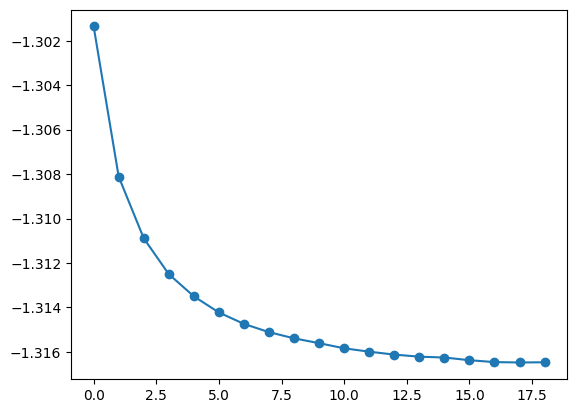

In [15]:
plt.plot(loss_history[1:], '-o')

In [16]:
# net.to('cpu')

In [17]:
test_dataloader = FastTensorDataLoader(patches, batch_size=10000, shuffle=False)

In [18]:
r = [[] for i in range(n_features)]
for i, data in enumerate(test_dataloader, 0): 
    x = data[0].to(device, non_blocking=True)
    with torch.no_grad():
        for ind, f in enumerate(net(x)):
            r[ind].append(f.to('cpu'))

In [19]:
out = [torch.cat(f) for f in r]

[3268561 3363322 3368116] 1.5848256211179825
[3304793 3373386 3321820] 1.5849073733710684


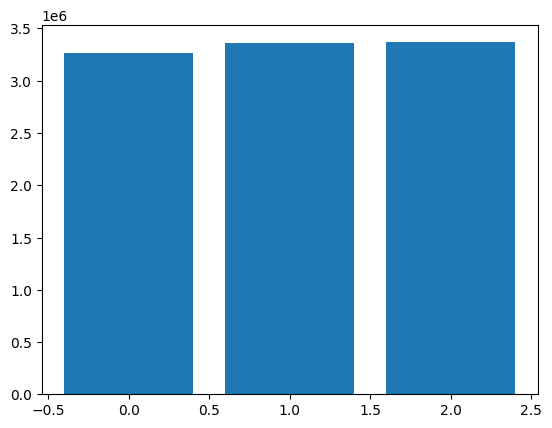

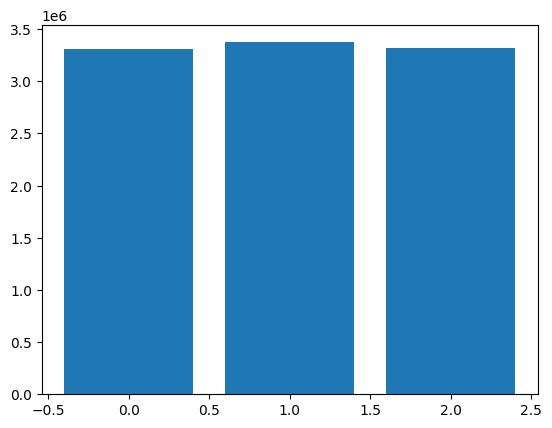

In [20]:
for oi in out:
    dist = oi.sum(dim=0).int().numpy()
    print(dist, entropy(dist, base=2))
    plt.figure()
    plt.bar(range(len(dist)), dist)

tensor(0.1160) tensor(0.1078) tensor(0.1111) 3.169624089032382


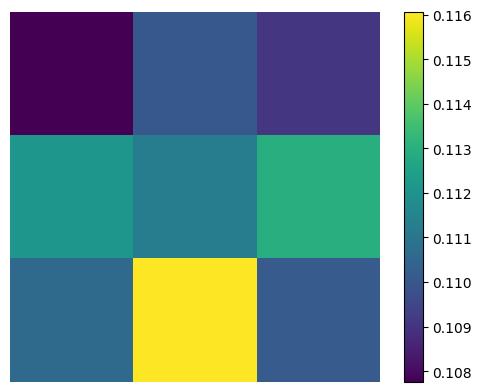

In [21]:
for couple in itertools.combinations(range(n_features), 2):
    y = outer_list(out, couple[0], couple[1])
    y_mean = y.mean(dim=0)
    s = entropy(y_mean.flatten(), base=2)
    print(y_mean.max(), y_mean.min(), y_mean.mean(), s)
    plt.figure()
    plt.imshow(y.mean(dim=0).numpy())
    plt.colorbar()
    plt.axis('off')

In [22]:
active_neuron = [torch.argmax(oi, dim=1).numpy() for oi in out]

In [23]:
# Total entropy
ngram = np.zeros(n_outputs)
an_array = np.array(active_neuron).transpose()
for ind in an_array:
    ngram[tuple(ind)] += 1
print(entropy(ngram.flatten(), base=2))

3.169624553771986


In [24]:
round_out = [oi.round() for oi in out]

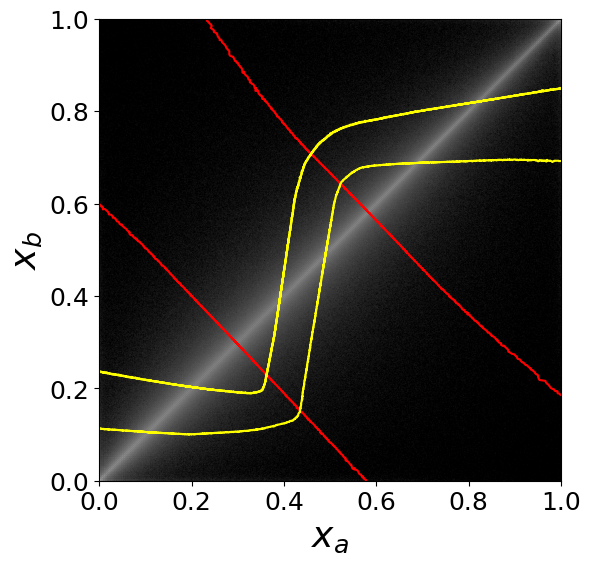

In [25]:
# Partition plot for 2 pixels
data = patches.squeeze().cpu().numpy()
H, xedges, yedges = np.histogram2d(data[:,0], data[:, 1], bins=1000)

X = patches[:,:, 0].flatten().cpu().numpy()
Y = patches[:,:, 1].flatten().cpu().numpy()
Z0 = active_neuron[0]
Z1 = active_neuron[1]
# Z2 = active_neuron[2]

fig, ax = plt.subplots(figsize=(6,6))

# Create an image plot
img = ax.imshow(np.log(H + 1), cmap='gray', origin='lower', extent=[0, 1, 0, 1])


# # Add a colorbar for the image plot
# cbar = fig.colorbar(img, ax=ax)
# cbar.ax.set_ylabel('Log Density', fontsize=16)

# Create a tricontour plot
b1 = ax.tricontour(X, Y, Z0, colors='red', locator=MaxNLocator(nbins=n_outputs[0], integer=True))
b2 = ax.tricontour(X, Y, Z1, colors='yellow', locator=MaxNLocator(nbins=n_outputs[1], integer=True))
# ax.tricontour(X, Y, Z2, colors='green', locator=MaxNLocator(nbins=n_outputs[2], integer=True))

# Create custom legend for the contour plots
# red_line = plt.Line2D([0], [0], color='red', lw=2, label='Basis 1 partitions')
# yellow_line = plt.Line2D([0], [0], color='yellow', lw=2, label='Basis 2 partitions')
# plt.legend(handles=[red_line], loc='lower right', fontsize=12)


# Add labels to the axes and a title to the plot
ax.set_xlabel('$x_a$', fontsize=26)
ax.set_ylabel('$x_b$', fontsize=26)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Increase the size of the axis ticks
ax.tick_params(axis='both', which='major', labelsize=18)

# Save the figure to a PNG file
plt.savefig('2px.png', dpi=300, bbox_inches='tight')

plt.show()
